In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import math
import matplotlib.pyplot as plt

from pandas import get_dummies
from sklearn import preprocessing
from sklearn import cross_validation, metrics 
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.metrics import mean_squared_error


%matplotlib inline
plt.style.use('ggplot')

In [2]:
from Bio.SeqUtils import ProtParamData  
from Bio.SeqUtils import IsoelectricPoint
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.Data import IUPACData
from Bio.SeqUtils import molecular_weight
from Bio import SeqIO
from Bio.SeqUtils import ProtParam

## Feature engineering 
* Log50000
* chemical structure
* kidera factors
* Phylogenetic tree

In [3]:
"""
logarithming according to articles
"""
def log_meas(current):
    new_meas = 1 - math.log(current, 50000.0)
    if new_meas > 1: new_meas = 1
    if new_meas < 0: new_meas = 0
    return new_meas

In [4]:
"""
analyse_seq adds to DataFrame data with peptide sequences  columnns with chemical attributes of peptide
"""

def analyse_seq(sequences):
    physochem = pd.DataFrame()
    mol_weight = []
    aromaticity = []
    instability_index = []
    isoelectric_point = []
    for i in sequences:
        X = ProtParam.ProteinAnalysis(i)
        mol_weight.append(X.molecular_weight())
        aromaticity.append(X.aromaticity())
        instability_index.append(X.instability_index())
        isoelectric_point.append(X.isoelectric_point())
    physochem["molecular_weight"] = mol_weight
    physochem["aromaticity"] = aromaticity
    physochem["instability_index"] = instability_index
    physochem["isoelectric_point"] = isoelectric_point
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(physochem[["molecular_weight","instability_index", "isoelectric_point"]])
    x_scaled = pd.DataFrame(x_scaled, columns=["molecular_weight","instability_index", "isoelectric_point"])
    physochem["molecular_weight"] = pd.DataFrame(x_scaled["molecular_weight"])
    physochem["instability_index"] = pd.DataFrame(x_scaled["instability_index"])
    physochem["isoelectric_point"] = pd.DataFrame(x_scaled["isoelectric_point"])
    return physochem

In [5]:
"""
to_one_hot function replaces "sequence" row in DataFrame data with OneHotEncoded sequences
"""
def to_one_hot(data, length):
    NMers = data[data["peptide_length"] == length].reset_index(drop=True)
    letters = NMers.sequence.apply(list) 
    #data_1Hot = pd.get_dummies(pd.DataFrame(list(letters)))
    #return pd.concat([NMers.drop(["sequence"], axis = 1), data_1Hot], axis = 1)
    return pd.get_dummies(pd.DataFrame(list(letters)))
    

In [6]:
"""
select_by_allele function returns DataFrame, which consists from data for one mhc by its allele
"""
def select_by_allele(data, allele):
    
    return data[data.mhc == allele].drop("mhc", axis = 1).reset_index(drop = True)

In [7]:
"""
add_kidera_ftr function returns DataFrame with kidera factors on column for a given peptide
"""
def add_kidera_ftr(peptides):
    kidera_peptides = pd.DataFrame()
    for i,fact in enumerate(f): 
        kidera_peptides[fact]=[add_kidera(j)[i] for j in peptides]
        #kidera_selected[fact] = pd.DataFrame(data[fact][indexes]).reset_index(drop=True)
    return kidera_peptides

amino=pd.read_csv("kidera_factors.csv", sep=" ", index_col=False)
d = amino.to_dict(orient='list')
f = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10']

def add_kidera(pept):
    seq = list(pept)
    dim = len(seq)
    kidera = [0]*10
    for i in range(10):
        kidera[i] = [0]*dim
       
    for k in range(dim):
        for i in range(20):
            if seq[k] == d['amino'][i]:
                for j in range(10):
                    kidera[j][k] = d[f[j]][i]
   
    for i in range(10):
        kidera[i] = sum(kidera[i])/len(kidera[i])
   
    return kidera

## Dataset

In [43]:
Bdata = pd.read_csv("../mhc/bdata.csv")
Bdata.meas = [log_meas(i) for i in Bdata.meas]
data9mers = Bdata[Bdata.peptide_length == 9]
peptides9mers = data9mers.sequence
sequences = Bdata.sequence
#le = preprocessing.LabelEncoder()
#mhc_labels = le.fit_transform(alleles_ABCE.mhc)

In [44]:
Bdata.tail()

,species,mhc,peptide_length,cv,sequence,inequality,meas
179687,human,HLA-C*12:03,9,TBD,IMDEPTSSL,=,1.0
179688,human,HLA-C*12:03,9,TBD,DAMPGVLSY,=,1.0
179689,human,HLA-C*12:03,9,TBD,YYFQSGNEI,=,1.0
179690,human,HLA-C*12:03,9,TBD,LMDENTYAM,=,1.0
179691,human,HLA-C*12:03,9,TBD,FAAFYFVFI,=,1.0


In [45]:
data9mers.tail()

,species,mhc,peptide_length,cv,sequence,inequality,meas
179687,human,HLA-C*12:03,9,TBD,IMDEPTSSL,=,1.0
179688,human,HLA-C*12:03,9,TBD,DAMPGVLSY,=,1.0
179689,human,HLA-C*12:03,9,TBD,YYFQSGNEI,=,1.0
179690,human,HLA-C*12:03,9,TBD,LMDENTYAM,=,1.0
179691,human,HLA-C*12:03,9,TBD,FAAFYFVFI,=,1.0


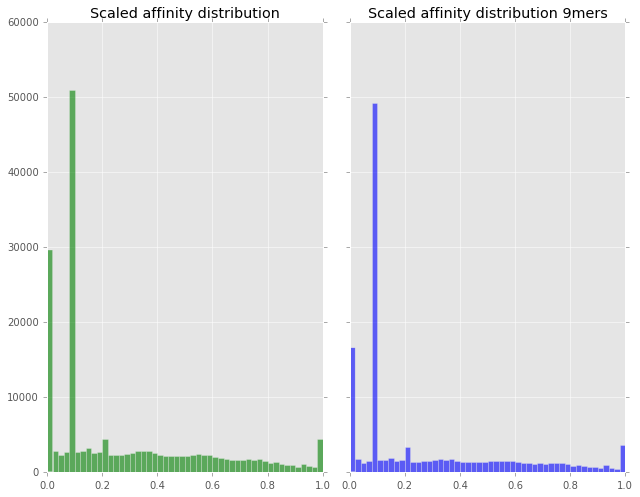

In [46]:
hist, (ax1, ax2) = plt.subplots(1, 2,figsize=(9,7), sharey=True)

ax1.set_title("Scaled affinity distribution")
hh =ax1.hist(Bdata.meas, 50, color = 'green', alpha = 0.6)

ax2.set_title("Scaled affinity distribution 9mers")
hh =ax2.hist(data9mers.meas, 50, color = 'blue', alpha = 0.6)
hist.tight_layout()
hist.subplots_adjust()


#### Selecting HLA alleles

In [47]:
def select_hla(data9mers):
    
    hlas = pd.Series([i[:5] for i in data9mers.mhc])
    A = hlas[hlas == "HLA-A"].index
    B = hlas[hlas == "HLA-B"].index
    C = hlas[hlas == "HLA-C"].index
    E = hlas[hlas == "HLA-E"].index
    
    alleles_ABCE = pd.concat([data9mers.iloc[A], data9mers.iloc[B],
                             data9mers.iloc[C], data9mers.iloc[E]], axis=0).reset_index(drop=True)
    alleles_ABCE.mhc = [i[:5] for i in alleles_ABCE.mhc]
    
    return alleles_ABCE

In [48]:
hla_abce = select_hla(data9mers)
hla_abce.tail()

,species,mhc,peptide_length,cv,sequence,inequality,meas
116950,human,HLA-E,9,TBD,VMMSEIAGL,=,0.124501
116951,human,HLA-E,9,TBD,VMTTVLATL,=,0.307237
116952,human,HLA-E,9,TBD,VSNLRTGKL,>,0.000000
116953,human,HLA-E,9,TBD,WLPPLLTNL,=,0.022964
116954,human,HLA-E,9,TBD,WMCDRAVDL,>,0.000000


## Sequence2Vector
* Word2Vec
* Doc2Vec
* Database of human proteins from uniprot.org
* Peptides from mhc binders

In [49]:
import logging
import os
import sys

import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import word2vec, Doc2Vec
from functools import partial

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = 20  # ipython messes up logging, restore root

/home/ubuntu/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [50]:
def fill_spaces(seq):
    new_seq = list(seq)
    for i in range(1, len(seq)):
        new_seq[i] = " "+ new_seq[i]
    return ''.join(new_seq)

def seq2vec(model, seq):
    return model[list(seq)].flatten()

def get_proteins_from_fasta(data_path):
    list_of_sequences = []
    for seq_record in SeqIO.parse(data_path, "fasta"):
        list_of_sequences.append((str(seq_record.seq)))
    return pd.Series(list_of_sequences).apply(fill_spaces)

def get_peptides_from_Bdata(sequences):
    return sequences.apply(fill_spaces)

def iterate_uniprot_labeled_ngrams(input_data, n=3):
    """
    Create n-gram sequence generator from the primary structure in
    the FASTA format. 
    :param input_data: str path to the input data
    :param n: int n-gram size
    """
    for seq_record in SeqIO.parse(input_data, "fasta"):
        ngrams = []
        sequence = str(seq_record.seq)
        for it in range(n):
            ngrams.extend(
                [sequence[i + it:i + n + it]
                 for i in range(0, len(sequence) - 1, n)
                 if len(sequence[i + it:i + n + it]) == n])
        yield TaggedDocument(words=ngrams, tags=[seq_record.id])
        


In [51]:
def train_seq2vec(data, epochs=5, min_word_count = 10, num_workers = 4,
                  context = 4, downsampling = 1e-3, w2v_dim = 20):
    
    if(isinstance(data, str)):
        sequences_for_w2v = get_proteins_from_fasta(data)
    else:
        sequences_for_w2v = get_peptides_from_Bdata(data)
    
    print("Training model...")
    w2v_model = word2vec.Word2Vec(sequences_for_w2v, workers=num_workers, size = w2v_dim,
                              min_count = min_word_count, window = context, sample = downsampling)

    print("Done.")

    return w2v_model   


def train_doc2vec(data_path, epochs=15, size=100, window=4, min_count=5, workers=8, ngram_size=3):
    """
    Train the Doc2Vec model on the protein primary structures data in the FASTA format.
    :param data_path: str path to the data
    :param epochs: int
    :param size: int
    :param window: int
    :param min_count: int
    :param workers: int
    :param ngram_size: int
    """
    it = lambda: iterate_uniprot_labeled_ngrams(data_path, n=3)
    model = gensim.models.Doc2Vec(size=size, window=window, min_count=min_count, workers=workers)
    model.build_vocab(it())
    for i in range(epochs):
        model.train(it())
        logging.info("PROGRESS epoch %s from %s", i + 1, epochs)
    return model

"""
if os.path.exists("protein_model.pkl"):
    # If model was already trained then just load it.
    protein_doc2vec = gensim.models.Doc2Vec.load("protein_model.pkl")
else:
    # Else let's train and save it for later reuse.
    protein_doc2vec = train_model("../mhc/uniprot-human.fasta")
    protein_doc2vec.save("protein_model.pkl")
    """



'\nif os.path.exists("protein_model.pkl"):\n    # If model was already trained then just load it.\n    protein_doc2vec = gensim.models.Doc2Vec.load("protein_model.pkl")\nelse:\n    # Else let\'s train and save it for later reuse.\n    protein_doc2vec = train_model("../mhc/uniprot-human.fasta")\n    protein_doc2vec.save("protein_model.pkl")\n    '

In [52]:
if os.path.exists("protein_model.pkl"):
    # If model was already trained then just load it.
    w2v_proteins = gensim.models.Doc2Vec.load("protein_model.pkl")
else:
    # Else let's train and save it for later reuse
    w2v_proteins = train_seq2vec("../mhc/uniprot-human.fasta")
    w2v_proteins.save("protein_model.pkl")
    
if os.path.exists("peptides_model.pkl"):
    # If model was already trained then just load it.
    w2v_peptides = gensim.models.Doc2Vec.load("peptides_model.pkl")
else:
    # Else let's train and save it for later reuse
    w2v_peptides = train_seq2vec(sequences)
    w2v_peptides.save("peptides_model.pkl")
    


## Dataframes with 9mers peptides

#### 1. Sequence embedding
##### 1.1 Proteins from UniProt

In [19]:
seq2vec9mers_proteins = pd.DataFrame(peptides9mers.apply(partial(seq2vec, w2v_proteins))).reset_index(drop=True)
seq2vec9mers_proteins = pd.DataFrame(list(seq2vec9mers_proteins.sequence))
seq2vec9mers_proteins.tail()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
129808,-0.070466,-1.132948,-0.496687,0.235803,-0.910053,-0.877142,-0.696909,-0.258628,-0.852915,1.091042,...,0.827864,0.796960,-0.204607,-0.807937,-0.245499,1.427431,-0.394118,-0.642358,0.442655,-0.445520
129809,-0.735324,-0.406569,-0.520339,1.181557,-0.196739,-2.291299,0.563426,-0.266201,-0.018502,0.150823,...,1.017957,0.494816,1.114388,-0.740237,-0.997627,-0.390326,0.331035,-0.029821,1.254128,0.416820
129810,-1.162394,-0.790445,0.000995,0.473923,0.834163,-2.541387,1.149772,2.528838,-0.271030,2.552308,...,0.515076,0.488997,0.409078,-1.909338,-1.296944,0.901100,0.065749,-1.236402,-0.624258,0.489092
129811,0.331753,-1.250065,-0.097219,0.300101,-0.483161,0.953044,1.220211,0.358642,0.217377,-0.038371,...,1.378027,-0.421655,-1.407553,-1.144221,-1.934685,0.695509,0.253446,0.262271,0.211380,-0.235470
129812,-0.769455,-2.589313,0.133901,0.885098,-0.646268,-1.362573,1.128449,1.335465,-0.334080,1.075649,...,0.515076,0.488997,0.409078,-1.909338,-1.296944,0.901100,0.065749,-1.236402,-0.624258,0.489092


##### 1.2 Peptides from mhc binders

In [16]:
seq2vec9mers_peptides = pd.DataFrame(peptides9mers.apply(partial(seq2vec, w2v_peptides))).reset_index(drop=True)
seq2vec9mers_peptides = pd.DataFrame(list(seq2vec9mers_peptides.sequence))
seq2vec9mers_peptides.tail()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
129808,-0.147348,-0.447794,-0.182057,0.049279,0.160138,0.013314,-0.665189,-0.181651,-0.598852,0.315057,...,0.457616,0.179948,-0.166193,0.099045,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114
129809,-0.267257,-0.400613,-0.443055,0.015390,-0.172523,0.058740,-0.616768,-0.387740,-0.237128,0.467072,...,0.937162,-0.063937,-0.355156,0.098337,0.212170,0.342942,-0.209382,-0.099737,-0.295770,-0.413778
129810,-0.002574,-0.131166,-0.524530,0.279908,-0.008974,-0.229033,-0.335929,-0.240438,-0.635068,0.155294,...,0.756489,0.257649,-0.005416,0.007550,0.550952,0.362033,-0.204242,-0.083444,-0.061360,-0.416948
129811,-0.107841,-0.146827,-0.162623,-0.047710,0.267500,0.206269,-0.322246,-0.068581,-0.895151,0.322828,...,0.582383,0.151213,-0.508543,0.553957,0.434713,-0.006307,0.238440,-0.408525,-0.308953,-0.188611
129812,0.137728,-0.532681,-0.132943,0.346430,0.178617,-0.205046,-0.694645,0.190223,-0.605324,0.558594,...,0.756489,0.257649,-0.005416,0.007550,0.550952,0.362033,-0.204242,-0.083444,-0.061360,-0.416948


#### 1.3 HLA binders 

In [53]:
seq2vec_hla = pd.DataFrame(hla_abce.sequence.apply(partial(seq2vec, w2v_peptides)))
seq2vec_hla = pd.DataFrame(list(seq2vec_hla.sequence))
seq2vec_hla.tail()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
116950,-0.403594,-0.167728,-0.176990,0.427276,-0.115815,0.069033,-0.568581,-0.257702,-0.939433,0.014860,...,0.457616,0.179948,-0.166193,0.099045,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114
116951,-0.403594,-0.167728,-0.176990,0.427276,-0.115815,0.069033,-0.568581,-0.257702,-0.939433,0.014860,...,0.457616,0.179948,-0.166193,0.099045,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114
116952,-0.403594,-0.167728,-0.176990,0.427276,-0.115815,0.069033,-0.568581,-0.257702,-0.939433,0.014860,...,0.457616,0.179948,-0.166193,0.099045,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114
116953,0.094242,-0.601093,0.072151,-0.253544,0.367059,0.675651,0.192364,-0.041100,-0.320269,0.233489,...,0.457616,0.179948,-0.166193,0.099045,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114
116954,0.094242,-0.601093,0.072151,-0.253544,0.367059,0.675651,0.192364,-0.041100,-0.320269,0.233489,...,0.457616,0.179948,-0.166193,0.099045,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114


seq2vec_hla.to_csv("../mhc/w2v_hla.csv")

seq2vec_hla = pd.read_csv("w2v_hla.csv",index_col=0)#.reset_index(drop=True)

##### 1.3 Correlation matrix "between" embedding models

In [17]:
embedding_columns = seq2vec9mers_peptides.columns
correlation_matrix = seq2vec9mers_peptides.apply(lambda embedding_columns: seq2vec9mers_proteins.corrwith(embedding_columns))

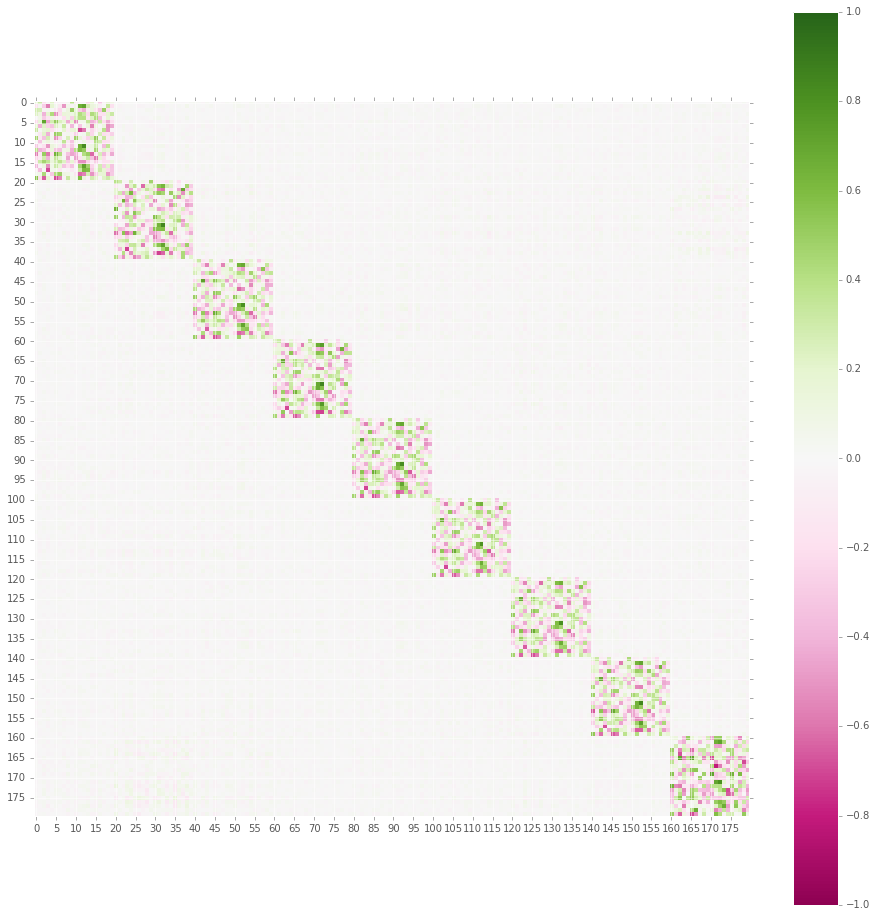

In [18]:
plt.figure(figsize = (16, 16))
plt.imshow(correlation_matrix, cmap='PiYG', interpolation='nearest', vmin=-1, vmax=1, )
plt.colorbar()
x_ = plt.xticks(np.arange(0, 180, 5), correlation_matrix.columns[::5])
y_ = plt.yticks(np.arange(0, 180, 5), correlation_matrix.columns[::5])

#### 2. OneHotEncoded

In [17]:
OneHot9mers = to_one_hot(Bdata, 9)
OneHot9mers.tail()

,0_A,0_C,0_D,0_E,0_F,0_G,0_H,0_I,0_K,0_L,...,8_M,8_N,8_P,8_Q,8_R,8_S,8_T,8_V,8_W,8_Y
129808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129809,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
129810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129812,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3. Physochemical properties

In [18]:
PhChemicalData = analyse_seq(peptides9mers)
PhChemicalData.tail()

,molecular_weight,aromaticity,instability_index,isoelectric_point
129808,0.372089,0.000000,0.280008,0.050803
129809,0.323164,0.111111,0.293921,0.064873
129810,0.528654,0.333333,0.353245,0.085869
129811,0.488379,0.111111,0.220120,0.050803
129812,0.533740,0.555556,0.264814,0.246062


#### 4.Kidera factors

In [21]:
KideraData = pd.read_csv("../mhc/Kidera9mers.csv").drop(["Unnamed: 0"], axis=1) #add_kidera_ftr(peptides9mers)
KideraData.tail()


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
129808,-0.011111,-0.355556,-0.186667,0.011111,-0.106667,-0.116667,-0.481111,-0.560000,-0.167778,-0.061111
129809,0.172222,-0.478889,-0.176667,-0.304444,0.096667,-0.404444,-0.238889,-0.028889,-0.250000,0.283333
129810,0.367778,0.122222,0.144444,0.002222,-0.051111,-0.146667,-0.062222,0.642222,0.040000,-0.567778
129811,-0.387778,-0.070000,-0.372222,0.003333,0.041111,0.073333,-0.040000,0.148889,-0.108889,0.062222
129812,-0.450000,0.132222,0.138889,-0.887778,-0.113333,-0.695556,0.007778,0.648889,0.823333,-0.368889


#### 5.BLOSUM scoring matrix

In [85]:
blosum_matrix = pd.read_csv("../mhc/blosum62.csv").drop(["x"], axis = 1)

def make_blosum(sequences):
    
    blosum_encoded = pd.DataFrame(np.zeros((len(sequences), 180)))
    for index, cur_seq in enumerate(sequences):
        amino_acids = list(cur_seq)
        cur_encoded_seq = np.array(blosum_matrix[amino_acids]).ravel()
        blosum_encoded.iloc[index] = np.array(blosum_matrix[amino_acids]).ravel()
        
    return blosum_encoded

blosum9mers = make_blosum(peptides9mers)

#### 6. kNN meta-features

In [19]:
from pandas import get_dummies
from sklearn.cluster import KMeans

In [69]:
def get_kMeans_features(data, k_range):
    kMeans_meta_features = pd.DataFrame()

    for i in k_range:
        clr = KMeans(n_clusters=i, verbose=100, n_jobs=8)
        clr.fit(data)
        kMeans_meta_features[str(i)+"Means"] = clr.labels_
    
    return pd.get_dummies(kMeans_meta_features)

In [21]:
if os.path.exists("kMeans_meta_features_pept.csv"):
    kMeans_meta_features_pept = pd.get_dummies(pd.read_csv("kMeans_meta_features_pept.csv").drop(["Unnamed: 0"], axis=1))
else:
    get_kMeans_features(seq2vec9mers_peptides, [2, 3, 100, 1000, 500])
    
if os.path.exists("kMeans_meta_features_prot.csv"):
    kMeans_meta_features_prot = pd.get_dummies(pd.read_csv("kMeans_meta_features_prot.csv").drop(["Unnamed: 0"], axis=1))
else:
    get_kMeans_features(seq2vec9mers_proteins, [2, 3, 100, 1000, 500])


In [70]:
kMeans_meta_features_prot = get_kMeans_features(seq2vec9mers_proteins, [2, 3, 50, 100, 500, 1000])

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration  0, inertia 61157644.624
Iteration  1, inertia 34723894.720
Iteration  2, inertia 34637565.667
Iteration  3, inertia 34590672.702


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete
Iteration  4, inertia 34548730.147
Iteration  0, inertia 60346684.232
Iteration  5, inertia 34511973.074
Iteration  1, inertia 35028043.278
Iteration  6, inertia 34475257.125
Iteration  2, inertia 34811404.274
Iteration  7, inertia 34444613.382
Iteration  3, inertia 34652642.621
Iteration  8, inertia 34415718.659


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete
Iteration  4, inertia 34502270.430
Iteration  9, inertia 34393128.608
Iteration  0, inertia 59858297.961
Iteration  5, inertia 34400194.833
Iteration 10, inertia 34370162.029
Iteration  1, inertia 34750870.332
Iteration  6, inertia 34352457.790
Iteration 11, inertia 34345921.113
Iteration  2, inertia 34632319.930
Iteration  7, inertia 34342863.602
Iteration 12, inertia 34319587.000
Iteration  3, inertia 34521122.911


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete
Iteration  8, inertia 34342730.274
Converged at iteration 8
Iteration 13, inertia 34292591.261
Iteration  4, inertia 34459673.929
Iteration  0, inertia 64361125.472
Iteration 14, inertia 34271907.950
Iteration  5, inertia 34433046.018
Iteration  1, inertia 34857847.560
Iteration 15, inertia 34265042.707
Iteration  6, inertia 34420725.783
Iteration  2, inertia 34720432.967
Iteration 16, inertia 34264980.488
Converged at iteration 16
Iteration  7, inertia 34416527.953
Iteration  3, inertia 34645584.925


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete
Iteration  8, inertia 34414222.071
Iteration  4, inertia 34604517.965
Iteration  0, inertia 62618531.240
Iteration  9, inertia 34412194.069
Iteration  5, inertia 34575445.764
Iteration  1, inertia 34745751.003
Iteration 10, inertia 34410422.519
Iteration  6, inertia 34552380.511
Iteration  2, inertia 34557532.521
Iteration 11, inertia 34409261.494
Iteration  7, inertia 34531316.192
Iteration  3, inertia 34481376.589
Iteration 12, inertia 34408081.506


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete
Iteration  8, inertia 34508690.573
Iteration  4, inertia 34444961.244
Iteration 13, inertia 34406873.907
Iteration  0, inertia 65898576.445
Iteration  9, inertia 34484403.390
Iteration 14, inertia 34405252.628
Iteration  5, inertia 34420837.772
Iteration  1, inertia 34820612.751
Iteration 10, inertia 34458289.495
Iteration 15, inertia 34403360.398
Iteration  6, inertia 34404035.240
Iteration  2, inertia 34703132.696
Iteration 11, inertia 34430727.851
Iteration  7, inertia 34392010.750
Iteration 16, inertia 34401223.507
Iteration 12, inertia 34393258.154


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration  3, inertia 34602646.188
Iteration 17, inertia 34397528.709
Initialization complete
Iteration  8, inertia 34381576.765
Iteration  4, inertia 34515714.347
Iteration 13, inertia 34339417.092
Iteration 18, inertia 34390295.924
Iteration  0, inertia 61946185.667
Iteration  5, inertia 34450626.996
Iteration 19, inertia 34378828.007
Iteration  1, inertia 34816927.701
Iteration  6, inertia 34397084.095
Iteration 20, inertia 34363758.552
Iteration  2, inertia 34728838.457
Iteration  9, inertia 34369979.490
Iteration  7, inertia 34350547.271
Iteration 21, inertia 34349152.200
Iteration 14, inertia 34302325.698


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete
Iteration  3, inertia 34676792.838
Iteration 10, inertia 34357362.121
Iteration  8, inertia 34305804.102
Iteration 22, inertia 34342791.411
Iteration 15, inertia 34269102.782
Iteration  0, inertia 59646644.695
Iteration  4, inertia 34640295.029
Iteration 11, inertia 34341998.923
Iteration  9, inertia 34276018.389
Iteration 23, inertia 34342730.274
Iteration 16, inertia 34264984.125
Converged at iteration 16
Converged at iteration 23
Iteration  1, inertia 34742853.001
Iteration  5, inertia 34614778.502
Iteration 10, inertia 34265146.394
Iteration 12, inertia 34323110.580
Iteration  2, inertia 34664660.593
Iteration  6, inertia 34595540.444
Iteration 11, inertia 34264980.488
Iteration 13, inertia 34300516.347
Converged at iteration 11
Iteration  3, inertia 34631227.686
Iteration  7, inertia 34576772.985


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete
Iteration 14, inertia 34278461.960
Iteration  4, inertia 34610628.097
Iteration  8, inertia 34555196.591
Iteration  0, inertia 65062120.155
Iteration 15, inertia 34266360.864
Iteration  5, inertia 34594910.978
Iteration  9, inertia 34533050.332
Iteration  1, inertia 34568171.504
Iteration 16, inertia 34264984.345
Converged at iteration 16
Iteration  6, inertia 34581202.929
Iteration 10, inertia 34507693.049
Iteration  2, inertia 34459271.272
Iteration 11, inertia 34485500.126
Iteration  7, inertia 34568042.629
Iteration  3, inertia 34428121.360
Initialization complete
Iteration 12, inertia 34467983.257
Iteration  8, inertia 34555645.042
Iteration  4, inertia 34410791.585
Iteration  0, inertia 62293726.058
Iteration 13, inertia 34455107.885
Iteration  9, inertia 34541357.618
Iteration  5, inertia 34400601.272
Iteration  1, inertia 34765365.705
Iteration 14, inertia 34447196.767
Iteration 10, inertia 34522229.348
Iteration  6, inertia 34391315.157
Iteration  2, in

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete
Iteration  0, inertia 59317298.730
Iteration  1, inertia 34136412.613
Iteration  2, inertia 33927066.447


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration  3, inertia 33868252.613
Initialization complete
Iteration  4, inertia 33841751.259
Iteration  0, inertia 58524810.185
Iteration  5, inertia 33826183.570
Iteration  1, inertia 34137401.119
Iteration  6, inertia 33812996.403
Iteration  2, inertia 33887822.141


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration  7, inertia 33799190.079
Initialization complete
Iteration  3, inertia 33794035.750
Iteration  8, inertia 33783414.804
Iteration  0, inertia 56915334.987
Iteration  4, inertia 33742049.528
Iteration  9, inertia 33765163.129
Iteration  1, inertia 34221177.920
Iteration  5, inertia 33704264.924
Iteration 10, inertia 33743447.248
Iteration  6, inertia 33684426.346
Iteration  2, inertia 34050287.868


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete
Iteration 11, inertia 33719856.002
Iteration  7, inertia 33671647.509
Iteration  3, inertia 33955343.026
Iteration  4, inertia 33875651.902
Iteration 12, inertia 33701373.133
Iteration  8, inertia 33660031.359
Iteration  0, inertia 60009444.600
Iteration  9, inertia 33647516.081
Iteration  5, inertia 33828593.277
Iteration  1, inertia 34302317.962
Iteration 13, inertia 33682575.426
Iteration  6, inertia 33813335.475
Iteration 10, inertia 33635311.512
Iteration  2, inertia 34019772.266


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration 14, inertia 33665229.763
Iteration 11, inertia 33621276.088
Iteration  7, inertia 33806314.585
Iteration  3, inertia 33882801.912
Initialization complete
Iteration 15, inertia 33647749.469
Iteration  8, inertia 33797803.866
Iteration  0, inertia 60384796.866
Iteration  9, inertia 33785424.282
Iteration 16, inertia 33629124.119
Iteration  1, inertia 34184132.251
Iteration 10, inertia 33766913.855
Iteration 17, inertia 33608848.984
Iteration 12, inertia 33608562.576
Iteration  4, inertia 33801891.080


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration  2, inertia 33946357.493
Iteration 11, inertia 33742615.322
Iteration 18, inertia 33586781.348
Initialization complete
Iteration 13, inertia 33602005.024
Iteration  5, inertia 33766726.525
Iteration  3, inertia 33805912.315
Iteration 12, inertia 33713432.259
Iteration 19, inertia 33562033.335
Iteration  0, inertia 58352617.192
Iteration 14, inertia 33601425.500
Iteration  6, inertia 33740614.926
Iteration 13, inertia 33684964.409
Iteration  1, inertia 34201686.527
Iteration 15, inertia 33601281.617
Iteration  7, inertia 33704064.608
Iteration 14, inertia 33664237.653


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration  2, inertia 34014656.508
Iteration  8, inertia 33656941.384
Iteration 16, inertia 33601224.382
Iteration  4, inertia 33704510.292
Initialization complete
Iteration 15, inertia 33648946.016
Iteration  9, inertia 33621409.093
Iteration 20, inertia 33537363.213
Iteration 17, inertia 33601184.129
Iteration  3, inertia 33931651.452
Iteration  0, inertia 59787397.441
Iteration 10, inertia 33599927.471
Iteration  1, inertia 33939537.052
Iteration  4, inertia 33876195.873
Iteration 16, inertia 33638924.011
Iteration 11, inertia 33574506.409
Iteration  5, inertia 33649754.876
Iteration 21, inertia 33503091.947
Iteration 18, inertia 33601176.172


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration  5, inertia 33831013.400
Iteration  2, inertia 33658523.157
Iteration 12, inertia 33538799.043
Iteration 17, inertia 33630459.962
Initialization complete
Iteration 19, inertia 33601168.907
Iteration  6, inertia 33785245.735
Iteration  3, inertia 33536405.216
Iteration 13, inertia 33522127.084
Iteration 18, inertia 33624295.445
Iteration  6, inertia 33613536.973
Iteration  0, inertia 53767672.726
Iteration 22, inertia 33499896.634
Converged at iteration 22
Iteration 20, inertia 33601160.536
Converged at iteration 20
Iteration  7, inertia 33741809.272
Iteration  4, inertia 33486423.692
Iteration 14, inertia 33521537.330
Converged at iteration 14
Iteration 19, inertia 33615820.037
Iteration  1, inertia 34394026.673
Iteration  7, inertia 33591325.359
Iteration  8, inertia 33713400.491
Iteration  5, inertia 33459180.060
Iteration 20, inertia 33605683.515


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration  2, inertia 34139205.354
Iteration  9, inertia 33698880.804
Iteration  6, inertia 33436568.097
Iteration  8, inertia 33572847.930
Iteration 21, inertia 33594539.363
Initialization complete
Iteration  3, inertia 33981348.582
Iteration  7, inertia 33414581.237
Iteration 10, inertia 33690904.997
Iteration  9, inertia 33552318.707
Iteration 22, inertia 33576655.917
Iteration  0, inertia 59053167.894
Iteration  4, inertia 33882661.083
Iteration 10, inertia 33526400.374
Iteration  8, inertia 33397523.781
Iteration 11, inertia 33685424.806
Iteration 23, inertia 33550918.358
Iteration  1, inertia 34284163.078
Iteration  5, inertia 33828067.503
Iteration  9, inertia 33390218.974
Iteration 12, inertia 33681804.669
Iteration 24, inertia 33524900.599
Iteration 11, inertia 33485483.408
Iteration  2, inertia 34136759.176
Iteration  6, inertia 33790424.173
Iteration 10, inertia 33389732.701
Iteration 13, inertia 33679910.731
Initialization complete
Iteration 25, inertia 33511343.986
Iterati

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view 

Initialization complete


/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Initialization complete
Iteration  0, inertia 40732280.732
Iteration  0, inertia 40446050.824
Initialization complete
Iteration  1, inertia 28488271.013
Iteration  1, inertia 28476722.419
Iteration  0, inertia 40971208.401
Initialization complete
Iteration  2, inertia 27687602.858
Iteration  2, inertia 27704125.770
Iteration  1, inertia 28518703.794
Initialization complete
Iteration  3, inertia 27385509.319
Iteration  0, inertia 41306260.526
Iteration  0, inertia 41206179.459
Iteration  2, inertia 27823478.751
Iteration  3, inertia 27416295.164
Iteration  1, inertia 28583269.349
Iteration  1, inertia 28528274.575
Iteration  4, inertia 27228730.088
Initialization complete
Iteration  3, inertia 27492047.847
Iteration  2, inertia 27833375.402
Initialization complete
Iteration  2, inertia 27784304.404
Iteration  4, inertia 27268306.860
Iteration  0, inertia 40685779.445
Iteration  5, inertia 27144035.434
Iteration  0, inertia 40241424.077
Iteration  4, inertia 27303144.266
Iteration  3, in

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration 36, inertia 26835979.253
Iteration 16, inertia 26958337.962
Iteration 22, inertia 26882082.794
Iteration 39, inertia 26865561.868
Iteration 44, inertia 26817317.027
Iteration 37, inertia 26829841.790
Iteration 34, inertia 26829487.064
Iteration 23, inertia 26880557.816
Iteration 17, inertia 26951874.467
Iteration 40, inertia 26865324.197
Iteration 37, inertia 26834494.540
Iteration 45, inertia 26816802.804
Iteration 38, inertia 26829464.857
Iteration 18, inertia 26946718.811
Iteration 41, inertia 26865227.431
Iteration 35, inertia 26828456.987
Iteration 24, inertia 26879096.072
Iteration 39, inertia 26828984.694
Iteration 46, inertia 26816345.852
Iteration 19, inertia 26941016.841
Iteration 38, inertia 26833780.231
Iteration 42, inertia 26865139.229
Iteration 40, inertia 26828398.283
Iteration 25, inertia 26877798.187
Iteration 36, inertia 26827393.542
Iteration 43, inertia 26864954.997
Iteration 41, inertia 26827391.708
Iteration 39, inertia 26832861.991
Iteration 47, inerti

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view 

Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Iteration  0, inertia 37381278.880
Iteration  0, inertia 37463203.410
Iteration  0, inertia 37810438.261
Iteration  0, inertia 37685366.805
Iteration  0, inertia 37070152.821
Iteration  0, inertia 37340682.754
Iteration  1, inertia 26813101.014
Iteration  1, inertia 26867499.121
Iteration  1, inertia 26941536.068
Iteration  1, inertia 26788093.454
Iteration  1, inertia 26793368.106
Iteration  1, inertia 26818110.748
Iteration  2, inertia 26120606.614
Iteration  2, inertia 26162831.435
Iteration  2, inertia 26246467.409
Iteration  2, inertia 26163063.260
Iteration  2, inertia 26131756.705
Iteration  2, inertia 26138092.914
Iteration  3, inertia 25837637.426
Iteration  3, inertia 25949670.814
Iteration  3, inertia 25865814.929
Iteration  3, inertia 25906600.598
Iteration  3, inertia 25882140.342
Ite

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration 39, inertia 25213089.758
Iteration 39, inertia 25273950.894
Iteration 39, inertia 25244654.580
Iteration 40, inertia 25213072.179
Iteration 40, inertia 25272791.067
Iteration 40, inertia 25244645.831
Iteration 41, inertia 25213071.874
Iteration 41, inertia 25271978.305
Converged at iteration 41
Initialization complete
Iteration 41, inertia 25244633.643
Iteration 27, inertia 25239901.533
Iteration 42, inertia 25271799.947
Iteration  0, inertia 37556692.170
Iteration 42, inertia 25244625.985
Converged at iteration 42
Iteration 43, inertia 25271668.700
Iteration  1, inertia 26850312.169
Initialization complete
Iteration 44, inertia 25271621.185
Iteration  2, inertia 26125980.747
Iteration  0, inertia 37368019.283
Iteration 45, inertia 25271587.816
Iteration  3, inertia 25848513.796
Iteration 28, inertia 25268088.224
Iteration  1, inertia 26799854.820
Iteration 46, inertia 25271561.215
Iteration  4, inertia 25698603.774
Iteration  2, inertia 26156313.995
Iteration 47, inertia 252

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view 

Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Iteration  0, inertia 29162331.318
Iteration  0, inertia 29006166.024
Iteration  0, inertia 29274204.518
Iteration  0, inertia 29118516.149
Initialization complete
Initialization complete
Iteration  1, inertia 21486183.916
Iteration  0, inertia 29161128.118
Iteration  1, inertia 21374961.489
Iteration  1, inertia 21463545.088
Iteration  1, inertia 21503914.433
Iteration  0, inertia 28999264.621
Iteration  2, inertia 21015459.283
Iteration  1, inertia 21485046.353
Iteration  2, inertia 20932678.344
Iteration  2, inertia 20970934.828
Iteration  2, inertia 21024831.587
Iteration  1, inertia 21431527.310
Iteration  3, inertia 20827426.068
Iteration  2, inertia 20997509.805
Iteration  3, inertia 20765093.517
Iteration  3, inertia 20802845.999
Iteration  3, inertia 20861919.584
Iteration  2, inertia 20966249.114
Iteration  4, inertia 20727717.823
Ite

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration 22, inertia 20509009.402
Iteration 21, inertia 20532324.633
Iteration  3, inertia 20791311.737
Iteration  4, inertia 20662923.517
Iteration 21, inertia 20573492.037
Iteration 23, inertia 20508974.336
Iteration 22, inertia 20531855.614
Iteration  4, inertia 20703740.058
Iteration  5, inertia 20612720.615
Iteration 22, inertia 20573063.266
Iteration 24, inertia 20508957.496
Iteration 23, inertia 20530800.454
Iteration  5, inertia 20650671.486
Iteration  6, inertia 20583074.795
Iteration 23, inertia 20572307.463
Iteration 11, inertia 20563066.243
Iteration 25, inertia 20508956.507
Converged at iteration 25
Iteration 24, inertia 20530194.365
Iteration  6, inertia 20619381.646
Initialization complete
Iteration  7, inertia 20562299.215
Iteration 24, inertia 20572087.821
Iteration 25, inertia 20529892.564
Iteration  7, inertia 20597001.054
Iteration  0, inertia 29067151.136
Iteration  8, inertia 20540480.437
Iteration 25, inertia 20572009.665
Iteration 26, inertia 20529715.017
Itera

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view 

Initialization complete
Initialization complete
Initialization complete
Initialization complete
Iteration  0, inertia 24545930.922
Iteration  0, inertia 24399575.891
Iteration  0, inertia 24453552.042
Iteration  0, inertia 24400332.937
Iteration  1, inertia 18113519.306
Iteration  1, inertia 18062938.345
Iteration  1, inertia 18069993.596
Iteration  1, inertia 18060680.195
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Iteration  2, inertia 17748662.302
Iteration  2, inertia 17722291.385
Iteration  2, inertia 17705928.864
Iteration  2, inertia 17705241.891
Iteration  0, inertia 24473961.632
Iteration  3, inertia 17633894.534
Iteration  3, inertia 17606275.217
Iteration  0, inertia 24455814.089
Iteration  3, inertia 17583395.416
Iteration  3, inertia 17598215.435
Iteration  1, inertia 18054150.166
Iteration  4, inertia 17576212.123
Iteration  4, inertia 17547787.436
Iteration  1, inertia 18084951.184
Iteration  4, inertia 17526956.520
Ite

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Iteration 22, inertia 17454012.509
Iteration  6, inertia 17479254.569
Iteration 22, inertia 17440844.025
Iteration 20, inertia 17408361.416
Iteration 23, inertia 17480165.603
Iteration 23, inertia 17453620.949
Iteration  7, inertia 17467856.745
Iteration 23, inertia 17440775.572
Iteration 21, inertia 17408127.087
Iteration 24, inertia 17479947.770
Iteration 24, inertia 17453132.936
Iteration  8, inertia 17458517.913
Iteration 24, inertia 17440308.807
Iteration 22, inertia 17408049.408
Iteration 25, inertia 17479829.980
Iteration 25, inertia 17452855.564
Iteration  9, inertia 17453979.622
Iteration 25, inertia 17440271.332
Initialization complete
Iteration 23, inertia 17407947.464
Iteration 26, inertia 17479784.611
Iteration 26, inertia 17452637.027
Iteration 10, inertia 17449912.393
Iteration 26, inertia 17440228.127
Iteration  0, inertia 24427698.342
Iteration 24, inertia 17407823.139
Iteration 27, inertia 17479778.730
Converged at iteration 27
Iteration 27, inertia 17452609.849
Itera

### 6.1. Correlation between kMeans on peptides and proteins

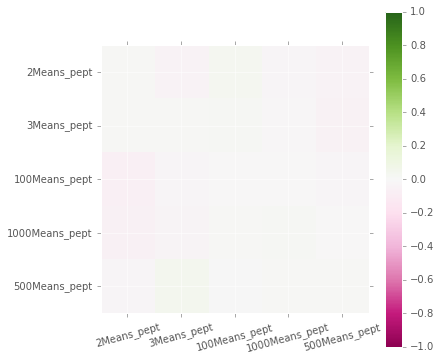

In [126]:
#clustering_columns = kMeans_meta_features_pept.columns

KMeans_correlation_matrix = kMeans_meta_features_pept.apply(lambda clustering_columns: kMeans_meta_features_prot.corrwith(clustering_columns))
plt.figure(figsize = (6, 6))
plt.imshow(KMeans_correlation_matrix, cmap='PiYG', interpolation='nearest', vmin=-1, vmax=1, )
plt.colorbar()
x_ = plt.xticks(range(len(KMeans_correlation_matrix)), KMeans_correlation_matrix.columns, rotation=15)
y_ = plt.yticks(range(len(KMeans_correlation_matrix)), KMeans_correlation_matrix.columns)

### 7. t-SNE

In [108]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [109]:
tsne = TSNE(n_jobs=14, verbose=5)

In [110]:
hla_tsne = tsne.fit_transform(seq2vec_hla.as_matrix())
np.save('hla_tsne_150.npy', hla_tsne) 

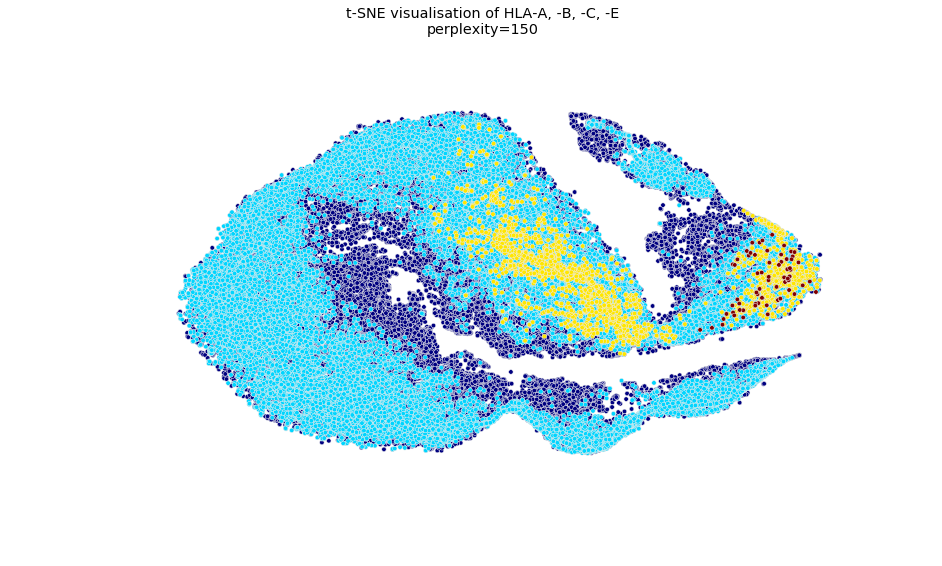

In [111]:
plt.figure(figsize=(16, 9))
plt.title("t-SNE visualisation of HLA-A, -B, -C, -E\nperplexity=150")
plt.scatter(hla_tsne[:,0], hla_tsne[:,1], c = mhc_labels)
plt.savefig('tsne_hla-abce_150.png', dpi='figure')
ax = plt.axis('off')

### 8. 1hot encoded alleles
* seq2vec_peptides  + 1HotAlleles(HLA-A, B, C, E;Mamu, BolA and etc. without specifity)
* seq2vec_hla + 1HotHLA(same)


In [41]:
pd.concat([seq2vec_hla, pd.get_dummies(alleles_ABCE.mhc).reset_index(drop=True)], axis=1, copy=False).tail()

,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,HLA-A,HLA-B,HLA-C,HLA-E
116950,-0.403594,-0.167728,-0.176990,0.427276,-0.115815,0.069033,-0.568581,-0.257702,-0.939433,0.014860,...,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114,0.0,0.0,0.0,1.0
116951,-0.403594,-0.167728,-0.176990,0.427276,-0.115815,0.069033,-0.568581,-0.257702,-0.939433,0.014860,...,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114,0.0,0.0,0.0,1.0
116952,-0.403594,-0.167728,-0.176990,0.427276,-0.115815,0.069033,-0.568581,-0.257702,-0.939433,0.014860,...,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114,0.0,0.0,0.0,1.0
116953,0.094242,-0.601093,0.072151,-0.253544,0.367059,0.675651,0.192364,-0.041100,-0.320269,0.233489,...,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114,0.0,0.0,0.0,1.0
116954,0.094242,-0.601093,0.072151,-0.253544,0.367059,0.675651,0.192364,-0.041100,-0.320269,0.233489,...,0.121977,0.179392,-0.223191,-0.464856,-0.420709,-0.411114,0.0,0.0,0.0,1.0


## Training XGboost

In [65]:
from sklearn.cross_validation import train_test_split

In [58]:
def affinity_to_classes(affinity):
    return pd.Series([round(10*i, 0) for i in affinity])

def affinity_to_binary(affinity):
    return pd.Series(map(lambda x: 1 if x >= 0.5 else 0, affinity))

In [59]:
def xgb_grid_search(data, target):
    
    # split
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    # train
    
    gbm_params = {
        'min_child_weight': [4, 7], 
        'gamma':[i/10.0 for i in range(0,5)]
    }
    
    print("GridSeachCV proceeding...")
    gbm = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', max_depth = 7, max_delta_step = 5, learning_rate = 0.15, scale_pos_weight = 2), gbm_params, n_jobs=2, cv=5, verbose=10)
    gbm.fit(X_train, y_train)
    print("Done.")
    
    print(101*"="+ "\nBEST PARAMETERS: ", gbm.best_params_, "\n"+101*"="+"\n")
    predictions = gbm.predict(X_test)
    
    print("==================\nACCURACY : %.4g\n==================" % metrics.roc_auc_score(y_test, predictions))
    

In [60]:
def xgb_grid_regression(data, target):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.25, random_state=442)
    
    
    """dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    bst = xgb.train(param, dtrain, num_round)
    preds = bst.predict(dtest)"""
    
    gbm_params = {
        'reg_lambda': [3]
    }
    

    print("GridSeachCV proceeding...")
    gbm = GridSearchCV(xgb.XGBRegressor(max_depth=9, learning_rate=0.1, n_estimators=750, gamma=0, min_child_weight=5,
                                        subsample=0.9, colsample_bytree = 0.9,
                                        nthread=14, silent=False), gbm_params, n_jobs=14, cv=3, verbose=10)
    gbm.fit(X_train, y_train)
    print("Done.")
    
    print(101*"="+ "\nBEST PARAMETERS(validation): ", gbm.best_params_, "\n"+101*"="+"\n")
    predictions = gbm.predict(X_test)
    
    print("==================\nRMSE on test : %.4g\n==================" % metrics.mean_squared_error(y_test, predictions))
    
    

In [73]:
def xgb_regression(data, target):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=442)
    
    T_train_xgb = xgb.DMatrix(X_train, y_train)
    params = {"objective": "reg:linear", 'max_depth':9,
              'learning_rate':0.1, 'n_estimators':750, 'gamma':0, 'min_child_weight':5, 
              'reg_lambda': 0.3, 'subsample': 0.9, 'colsample_bytree':0.9, 'nthread':15}
    cv_res=xgb.cv(xgb_params,xgall,100, 3, verbose_eval= 10,metrics='auc', folds=sample_cv )
    gbm = xgb.train(dtrain=T_train_xgb,params=params, num_boost_round=1000)
    pred = gbm.predict(xgb.DMatrix(X_test))
    print("RMSE on test: %.4f" % mean_squared_error(y_test, pred))
    
    """
   xgbr = xgb.XGBRegressor(max_depth=9, learning_rate=0.1, n_estimators=750, gamma=0, min_child_weight=5,
                            reg_lambda = 0.3, subsample=0.9, colsample_bytree = 0.9, nthread=15, silent=True)
    
    xgbr.fit(X_train, y_train)
    mse = mean_squared_error(y_test, xgbr.predict(X_test))
    print("RMSE on test: %.4f" % mse)"""


### Feature Selecting using GBM

In [61]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

In [62]:
# Feature selection 
#ROUND ONE
def gbm_feature_selection(data, target):
    
    cols = data.columns.values.tolist()
    clf = GradientBoostingClassifier(random_state=1729)
    selector = clf.fit(data, target)
    importances = selector.feature_importances_
    fs = SelectFromModel(selector, prefit=True)
    data = fs.transform(data)
    

    selected_cols = data.shape[1]
    sorted_cols = [col for importance, col  in sorted(zip(importances, cols))]
    sorted_cols = sorted_cols[0:selected_cols]
    data = pd.DataFrame(data)
    data.columns = sorted_cols
    
    #Selecting Percentile Changes from feature to feature

    for i in range(len(sorted_cols)):
        for j in range(len(sorted_cols)):
            col_name = sorted_cols[i]+"_SUBTRACT_"+sorted_cols[j]+"DIVIDE"+sorted_cols[i]
            data[col_name] = (data[sorted_cols[i]]-data[sorted_cols[j]])/data[sorted_cols[i]]
            
    data = data.replace(np.inf, 9999)
    data = data.replace(-np.inf, -9999)
    data = data.replace(np.nan, -1)
    
    #ROUND TWO
    cols = data.columns.values.tolist()
    clf = GradientBoostingClassifier(random_state=1729)
    selector = clf.fit(data, target)
    importances = selector.feature_importances_
    fs = SelectFromModel(selector, prefit=True)
    data = fs.transform(data)
    print(data.shape)

    selected_cols = data.shape[1]
    sorted_cols = [col for importance, col  in sorted(zip(importances, cols))]
    sorted_cols = sortedCols[0:selectedCols]
    data = pd.DataFrame(data)
    data.columns = sorted_cols
    #print(sorted_cols)
    return data

### Model evaluation

In [ ]:
affinity = Bdata[Bdata.peptide_length == 9].meas.reset_index(drop=True)
affinity_classes = affinity_to_classes(affinity)
affinity_binary = affinity_to_binary(affinity)

In [42]:
xgb_regression(pd.concat([seq2vec_hla, pd.DataFrame(hla_tsne, columns=["x_tsne", "y_tsne"])], axis = 1), affinity_hlas)

MSE: 0.0279


In [56]:
#learning_rate and n_estimators tuning
xgb_grid_regression(seq2vec_hla, affinity_hlas)

GridSeachCV proceeding...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] learning_rate=0.03, n_estimators=250 ............................
[CV] learning_rate=0.03, n_estimators=250 ............................
[CV] learning_rate=0.03, n_estimators=250 ............................
[CV] learning_rate=0.03, n_estimators=250 ............................
[CV] learning_rate=0.03, n_estimators=250 ............................
[CV] learning_rate=0.03, n_estimators=350 ............................
[CV] learning_rate=0.03, n_estimators=350 ............................
[CV] learning_rate=0.03, n_estimators=350 ............................
[CV] ... learning_rate=0.03, n_estimators=250, score=0.501796 - 4.5min
[CV] ... learning_rate=0.03, n_estimators=250, score=0.504094 - 4.4min
[CV] ... learning_rate=0.03, n_estimators=250, score=0.508536 - 4.4min
[CV] learning_rate=0.03, n_estimators=350 ............................


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  4.5min


[CV] ... learning_rate=0.03, n_estimators=250, score=0.512514 - 4.5min
[CV] learning_rate=0.03, n_estimators=350 ............................
[CV] learning_rate=0.03, n_estimators=450 ............................
[CV] learning_rate=0.03, n_estimators=450 ............................
[CV] ... learning_rate=0.03, n_estimators=250, score=0.519411 - 4.6min
[CV] learning_rate=0.03, n_estimators=450 ............................
[CV] ... learning_rate=0.03, n_estimators=350, score=0.540784 - 6.1min
[CV] learning_rate=0.03, n_estimators=450 ............................
[CV] ... learning_rate=0.03, n_estimators=350, score=0.546048 - 6.2min
[CV] learning_rate=0.03, n_estimators=450 ............................
[CV] ... learning_rate=0.03, n_estimators=350, score=0.550840 - 6.2min
[CV] learning_rate=0.1, n_estimators=250 .............................
[CV] ... learning_rate=0.03, n_estimators=350, score=0.557178 - 6.1min


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed: 10.6min


[CV] learning_rate=0.1, n_estimators=250 .............................
[CV] ... learning_rate=0.03, n_estimators=350, score=0.548400 - 6.3min
[CV] learning_rate=0.1, n_estimators=250 .............................
[CV] .... learning_rate=0.1, n_estimators=250, score=0.615753 - 4.6min
[CV] learning_rate=0.1, n_estimators=250 .............................
[CV] ... learning_rate=0.03, n_estimators=450, score=0.580255 - 7.9min
[CV] ... learning_rate=0.03, n_estimators=450, score=0.568875 - 7.9min
[CV] learning_rate=0.1, n_estimators=250 .............................
[CV] learning_rate=0.1, n_estimators=350 .............................
[CV] ... learning_rate=0.03, n_estimators=450, score=0.572337 - 8.0min
[CV] learning_rate=0.1, n_estimators=350 .............................
[CV] ... learning_rate=0.03, n_estimators=450, score=0.585527 - 7.9min
[CV] learning_rate=0.1, n_estimators=350 .............................
[CV] ... learning_rate=0.03, n_estimators=450, score=0.576208 - 8.2min


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 14.3min


[CV] learning_rate=0.1, n_estimators=350 .............................
[CV] .... learning_rate=0.1, n_estimators=250, score=0.624077 - 4.5min
[CV] learning_rate=0.1, n_estimators=350 .............................
[CV] .... learning_rate=0.1, n_estimators=250, score=0.623348 - 4.4min
[CV] learning_rate=0.1, n_estimators=450 .............................
[CV] .... learning_rate=0.1, n_estimators=250, score=0.622450 - 4.5min
[CV] learning_rate=0.1, n_estimators=450 .............................
[CV] .... learning_rate=0.1, n_estimators=250, score=0.638686 - 4.5min
[CV] learning_rate=0.1, n_estimators=450 .............................
[CV] .... learning_rate=0.1, n_estimators=350, score=0.633813 - 6.2min
[CV] learning_rate=0.1, n_estimators=450 .............................
[CV] .... learning_rate=0.1, n_estimators=350, score=0.645851 - 6.2min
[CV] learning_rate=0.1, n_estimators=450 .............................
[CV] .... learning_rate=0.1, n_estimators=350, score=0.640077 - 6.4min
[CV] .

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 21.4min


[CV] learning_rate=0.2, n_estimators=250 .............................
[CV] .... learning_rate=0.1, n_estimators=450, score=0.644461 - 7.9min
[CV] learning_rate=0.2, n_estimators=250 .............................
[CV] .... learning_rate=0.1, n_estimators=450, score=0.656223 - 8.0min
[CV] learning_rate=0.2, n_estimators=250 .............................
[CV] .... learning_rate=0.1, n_estimators=450, score=0.649077 - 8.0min
[CV] learning_rate=0.2, n_estimators=350 .............................
[CV] .... learning_rate=0.2, n_estimators=250, score=0.645555 - 4.5min
[CV] learning_rate=0.2, n_estimators=350 .............................
[CV] .... learning_rate=0.2, n_estimators=250, score=0.630325 - 4.5min
[CV] learning_rate=0.2, n_estimators=350 .............................
[CV] .... learning_rate=0.2, n_estimators=250, score=0.633519 - 4.5min
[CV] learning_rate=0.2, n_estimators=350 .............................
[CV] .... learning_rate=0.1, n_estimators=450, score=0.651301 - 7.9min
[CV] l

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 27.5min


[CV] learning_rate=0.2, n_estimators=450 .............................
[CV] .... learning_rate=0.2, n_estimators=250, score=0.645418 - 4.6min
[CV] learning_rate=0.2, n_estimators=450 .............................
[CV] .... learning_rate=0.2, n_estimators=350, score=0.636951 - 6.2min
[CV] learning_rate=0.2, n_estimators=450 .............................
[CV] .... learning_rate=0.2, n_estimators=350, score=0.652586 - 6.1min
[CV] learning_rate=0.2, n_estimators=450 .............................
[CV] .... learning_rate=0.2, n_estimators=350, score=0.639821 - 6.2min
[CV] learning_rate=0.3, n_estimators=250 .............................
[CV] .... learning_rate=0.2, n_estimators=350, score=0.640502 - 6.1min
[CV] learning_rate=0.3, n_estimators=250 .............................
[CV] .... learning_rate=0.2, n_estimators=350, score=0.652769 - 6.3min
[CV] learning_rate=0.3, n_estimators=250 .............................
[CV] .... learning_rate=0.2, n_estimators=450, score=0.639084 - 7.8min
[CV] l

[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 36.5min


[CV] learning_rate=0.3, n_estimators=350 .............................
[CV] .... learning_rate=0.3, n_estimators=250, score=0.615206 - 4.5min
[CV] learning_rate=0.3, n_estimators=350 .............................
[CV] .... learning_rate=0.2, n_estimators=450, score=0.643673 - 7.9min
[CV] learning_rate=0.3, n_estimators=350 .............................
[CV] .... learning_rate=0.3, n_estimators=250, score=0.628775 - 4.6min
[CV] learning_rate=0.3, n_estimators=450 .............................
[CV] .... learning_rate=0.2, n_estimators=450, score=0.655807 - 8.0min
[CV] learning_rate=0.3, n_estimators=450 .............................
[CV] .... learning_rate=0.3, n_estimators=250, score=0.641038 - 4.5min
[CV] learning_rate=0.3, n_estimators=450 .............................
[CV] .... learning_rate=0.3, n_estimators=350, score=0.615436 - 6.3min
[CV] learning_rate=0.3, n_estimators=450 .............................
[CV] .... learning_rate=0.3, n_estimators=350, score=0.638690 - 6.1min
[CV] l

[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed: 46.5min finished


Done.
BEST PARAMETERS:  {'learning_rate': 0.1, 'n_estimators': 450} 

MSE : 0.02627


In [62]:
#max_depth and min_child_weight tuning
xgb_grid_regression(seq2vec_hla, affinity_hlas)

GridSeachCV proceeding...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=3 .................................
[CV] max_depth=3, min_child_weight=3 .................................
[CV] max_depth=3, min_child_weight=3 .................................
[CV] ........ max_depth=3, min_child_weight=1, score=0.425176 - 2.9min
[CV] max_depth=3, min_child_weight=3 .................................
[CV] ........ max_depth=3, min_child_weight=1, score=0.440681 - 3.0min


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  3.0min


[CV] max_depth=3, min_child_weight=3 .................................
[CV] ........ max_depth=3, min_child_weight=3, score=0.425705 - 3.0min
[CV] max_depth=3, min_child_weight=5 .................................
[CV] ........ max_depth=3, min_child_weight=1, score=0.442295 - 3.0min
[CV] ........ max_depth=3, min_child_weight=1, score=0.431800 - 3.0min
[CV] ........ max_depth=3, min_child_weight=1, score=0.427035 - 3.0min
[CV] max_depth=3, min_child_weight=5 .................................
[CV] ........ max_depth=3, min_child_weight=3, score=0.443017 - 3.0min
[CV] max_depth=3, min_child_weight=5 .................................
[CV] max_depth=3, min_child_weight=5 .................................
[CV] ........ max_depth=3, min_child_weight=3, score=0.430168 - 3.0min
[CV] max_depth=3, min_child_weight=5 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] ........ max_depth=3, min_child_weight=3, score=0.427269 - 3.0min


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  5.9min


[CV] max_depth=5, min_child_weight=1 .................................
[CV] ........ max_depth=3, min_child_weight=5, score=0.426551 - 3.0min
[CV] max_depth=5, min_child_weight=1 .................................
[CV] ........ max_depth=3, min_child_weight=5, score=0.443477 - 3.0min
[CV] max_depth=5, min_child_weight=1 .................................
[CV] ........ max_depth=3, min_child_weight=3, score=0.441627 - 3.0min
[CV] max_depth=5, min_child_weight=1 .................................
[CV] ........ max_depth=3, min_child_weight=5, score=0.443615 - 3.0min
[CV] max_depth=5, min_child_weight=3 .................................
[CV] ........ max_depth=3, min_child_weight=5, score=0.432474 - 3.0min
[CV] ........ max_depth=3, min_child_weight=5, score=0.434056 - 3.0min
[CV] max_depth=5, min_child_weight=3 .................................
[CV] max_depth=5, min_child_weight=3 .................................
[CV] ........ max_depth=5, min_child_weight=1, score=0.583756 - 5.1min


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  8.2min


[CV] max_depth=5, min_child_weight=3 .................................
[CV] ........ max_depth=5, min_child_weight=1, score=0.595970 - 5.1min
[CV] max_depth=5, min_child_weight=3 .................................
[CV] ........ max_depth=5, min_child_weight=1, score=0.583168 - 5.1min
[CV] ........ max_depth=5, min_child_weight=1, score=0.601669 - 5.1min
[CV] ........ max_depth=5, min_child_weight=1, score=0.585274 - 5.1min
[CV] max_depth=5, min_child_weight=5 .................................
[CV] max_depth=5, min_child_weight=5 .................................
[CV] max_depth=5, min_child_weight=5 .................................
[CV] ........ max_depth=5, min_child_weight=3, score=0.586327 - 5.1min
[CV] max_depth=5, min_child_weight=5 .................................
[CV] ........ max_depth=5, min_child_weight=3, score=0.586943 - 5.1min
[CV] max_depth=5, min_child_weight=5 .................................
[CV] ........ max_depth=5, min_child_weight=3, score=0.590467 - 5.1min
[CV] m

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 16.1min


[CV] max_depth=7, min_child_weight=1 .................................
[CV] ........ max_depth=5, min_child_weight=5, score=0.582556 - 5.0min
[CV] max_depth=7, min_child_weight=1 .................................
[CV] ........ max_depth=5, min_child_weight=5, score=0.590463 - 5.1min
[CV] ........ max_depth=5, min_child_weight=5, score=0.599660 - 5.0min
[CV] max_depth=7, min_child_weight=1 .................................
[CV] ........ max_depth=5, min_child_weight=3, score=0.600251 - 5.1min
[CV] ........ max_depth=5, min_child_weight=5, score=0.592119 - 5.1min
[CV] max_depth=7, min_child_weight=3 .................................
[CV] max_depth=7, min_child_weight=3 .................................
[CV] max_depth=7, min_child_weight=3 .................................
[CV] ........ max_depth=7, min_child_weight=1, score=0.644461 - 8.2min
[CV] max_depth=7, min_child_weight=3 .................................
[CV] ........ max_depth=7, min_child_weight=1, score=0.656223 - 8.1min
[CV] m

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 24.1min


[CV] max_depth=7, min_child_weight=5 .................................
[CV] max_depth=7, min_child_weight=5 .................................
[CV] ........ max_depth=7, min_child_weight=3, score=0.657507 - 8.0min
[CV] max_depth=7, min_child_weight=5 .................................
[CV] ........ max_depth=7, min_child_weight=1, score=0.651301 - 8.0min
[CV] max_depth=7, min_child_weight=5 .................................
[CV] ........ max_depth=7, min_child_weight=1, score=0.665650 - 8.0min
[CV] max_depth=7, min_child_weight=5 .................................
[CV] ........ max_depth=7, min_child_weight=3, score=0.648435 - 8.0min
[CV] max_depth=9, min_child_weight=1 .................................
[CV] ........ max_depth=7, min_child_weight=3, score=0.646845 - 7.9min
[CV] max_depth=9, min_child_weight=1 .................................
[CV] ........ max_depth=7, min_child_weight=3, score=0.661489 - 7.8min
[CV] max_depth=9, min_child_weight=1 .................................
[CV] .

[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 32.1min


[CV] max_depth=9, min_child_weight=3 .................................
[CV] ........ max_depth=9, min_child_weight=1, score=0.660525 -12.1min
[CV] max_depth=9, min_child_weight=3 .................................
[CV] ........ max_depth=9, min_child_weight=1, score=0.669876 -12.2min
[CV] max_depth=9, min_child_weight=3 .................................
[CV] ........ max_depth=9, min_child_weight=1, score=0.660615 -12.0min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] ........ max_depth=9, min_child_weight=1, score=0.660916 -11.6min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] ........ max_depth=9, min_child_weight=1, score=0.674084 -11.6min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] ........ max_depth=9, min_child_weight=3, score=0.670698 -11.6min
[CV] max_depth=9, min_child_weight=5 .................................
[CV] ........ max_depth=9, min_child_weight=3, score=0.662349 -11.8min
[CV] m

[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed: 51.9min finished


Done.
BEST PARAMETERS:  {'max_depth': 9, 'min_child_weight': 5} 

MSE : 0.02447


In [72]:
#gamma tuning
xgb_grid_regression(seq2vec_hla, affinity_hlas)

GridSeachCV proceeding...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=600 ................................................
[CV] n_estimators=600 ................................................
[CV] n_estimators=600 ................................................
[CV] n_estimators=650 ................................................
[CV] n_estimators=650 ................................................
[CV] n_estimators=650 ................................................
[CV] n_estimators=750 ................................................
[CV] n_estimators=750 ................................................
[CV] ....................... n_estimators=600, score=0.649246 -13.2min


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 13.2min


[CV] n_estimators=750 ................................................
[CV] ....................... n_estimators=600, score=0.655594 -13.2min
[CV] n_estimators=800 ................................................
[CV] ....................... n_estimators=600, score=0.644591 -13.4min
[CV] n_estimators=800 ................................................
[CV] ....................... n_estimators=650, score=0.655698 -14.2min
[CV] n_estimators=800 ................................................
[CV] ....................... n_estimators=650, score=0.649461 -14.3min
[CV] ....................... n_estimators=650, score=0.644365 -14.4min
[CV] ....................... n_estimators=750, score=0.644435 -15.9min
[CV] ....................... n_estimators=750, score=0.649534 -15.9min
[CV] ....................... n_estimators=750, score=0.655868 - 8.6min
[CV] ....................... n_estimators=800, score=0.649346 - 9.0min
[CV] ....................... n_estimators=800, score=0.644369 - 8.9min
[CV] .

[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed: 22.4min finished


Done.
BEST PARAMETERS:  {'n_estimators': 750} 

MSE : 0.02428


In [122]:
#tree structure tuning
xgb_regression(seq2vec_hla, affinity_hlas)

RMSE on test: 0.0544


0.054430377026422283

In [116]:
### 1hot HLA
xgb_regression(seq2vec_hla, alleles_ABCE.meas)

RMSE on test: 0.0574


0.057399365144182896

In [74]:
xgb_regression(seq2vec_hla, hla_abce.meas)

RMSE on test: 0.0536


##  Pipeline

#### objective
* visualise RMSE on every allele

#### steps

* make dataset with sequences and affinities for specific allele
* construct word2vec representation of this sequences
* evaluate xgb model on it
* make 
    
#### important
* gather size of each dataset



In [18]:
def get_rmse_of_models(performance, alleles):
    
    """
    arguments:
    
    alleles - list of alleles names
    --------
    function get_rmse_of_models extract dataset of specific allele from performance dataset, calculates rmse on 
    each allele and stores it in dicts
    --------
    returns: 3 tuples
    
    netmhc_rmse - tuple of rmse of netmhc on every alelle
    netmhcpan_rmse - tuple of rmse of netmhcpan on every alelle
    pmbec_rmse - tuple of rmse of smm_pmbec on every alelle
    
    """
    
    netmhc_rmse = {}
    netmhcpan_rmse = {}
    pmbec_rmse = {}
    
    for index, cur_al in enumerate(alleles):
        
        cur_alelle = select_by_allele(performance, cur_al)
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", cur_alelle.shape, cur_alelle.meas.shape)
        if(len(cur_alelle) == 0):
            continue
        netmhc_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.netmhc)
        netmhcpan_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.netmhcpan)
        pmbec_rmse[cur_al] = mean_squared_error(cur_alelle.meas, cur_alelle.smmpmbec_cpp)
    
    return netmhc_rmse, netmhcpan_rmse, pmbec_rmse


def evaluate_by_allele(alleles):
    
    """
    arguments:
    
    alleles - list of alleles names
    --------
    function evaluate_by_allele extract dataset of specific allele from Bdata in which there are sequence and affinity 
    using select_by_allele function, saves it in csv, then constructing word2vec representation of this 
    sequences and evaluates xgb model, which return rmse on this allele.
    --------
    returns: 
    
    mhc_rmse tuple of rmse on every allele in alleles
    """
    
    mhc_rmse = {}
    for index,cur_al in enumerate(alleles):
        
        current_allele = select_by_allele(Bdata, cur_al)
        if(len(current_allele) == 1):
            continue
        seq2vec_allele = pd.DataFrame(current_allele.sequence.apply(partial(seq2vec, w2v_peptides)))
        seq2vec_allele = pd.DataFrame(list(seq2vec_allele.sequence))
        seq2vec_allele.to_csv("../mhc/w2v_allele#{:d}.csv".format(index))
        cur_al_affinity = current_allele.meas
        print("\n#{:d} {}:".format(index, cur_al))
        print("Shapes: ", current_allele.shape, cur_al_affinity.shape)
        allele_rmse = xgb_regression(seq2vec_allele, cur_al_affinity)
        mhc_rmse[cur_al] = allele_rmse
    
    return mhc_rmse
        
        
    
    

In [19]:
from operator import itemgetter
from collections import OrderedDict
import matplotlib.ticker as ticker
import re

In [30]:
performance_data = pd.read_csv("model_performance_logged.csv").drop("Unnamed: 0", axis=1)
alleles_models = performance_data.mhc.unique()
alleles = Bdata.mhc.unique()

new_allele_list = []

for i in list(errors.keys()):
    
    strs = re.sub('\*', '', i)
    strs = re.sub('\:', '', strs)
    new_allele_list.append(strs)

common_alleles = list(set(new_allele_list).intersection(alleles_models))
performance_data.tail()


,mhc,meas,netmhc,netmhcpan,smmpmbec_cpp
21377,Mamu-A02,0.747391,0.434557,0.605658,0.567139
21378,Mamu-A02,0.022339,0.293037,0.202166,0.371139
21379,Mamu-A02,0.028511,0.283247,0.148324,0.273245
21380,Mamu-A02,0.141940,0.079586,0.195356,0.143642
21381,Mamu-A02,0.535430,0.496485,0.389441,0.569267


errors = get_rmse_by_allele(alleles)
netmhc_rmse, netmhcpan_rmse, pmbec_rmse = get_rmse_of_models(performance_data, common_alleles)

In [31]:
errors = np.load('alleles_rmse.npy').item()
errors = OrderedDict(sorted(errors.items(), key=lambda t: t[0]))
netmhc_rmse, netmhcpan_rmse, pmbec_rmse = get_rmse_of_models(performance_data, common_alleles)


#0 HLA-A0202:
Shapes:  (126, 4) (126,)

#1 HLA-B1517:
Shapes:  (582, 4) (582,)

#2 HLA-A2601:
Shapes:  (1132, 4) (1132,)

#3 HLA-B0801:
Shapes:  (707, 4) (707,)

#4 HLA-A0206:
Shapes:  (482, 4) (482,)

#5 HLA-B5701:
Shapes:  (647, 4) (647,)

#6 Mamu-A01:
Shapes:  (73, 4) (73,)

#7 HLA-A2602:
Shapes:  (413, 4) (413,)

#8 HLA-A2603:
Shapes:  (312, 4) (312,)

#9 HLA-B1501:
Shapes:  (633, 4) (633,)

#10 HLA-A2501:
Shapes:  (416, 4) (416,)

#11 HLA-B5401:
Shapes:  (79, 4) (79,)

#12 HLA-B2705:
Shapes:  (249, 4) (249,)

#13 HLA-A3001:
Shapes:  (470, 4) (470,)

#14 HLA-B4002:
Shapes:  (74, 4) (74,)

#15 HLA-A8001:
Shapes:  (379, 4) (379,)

#16 HLA-A2301:
Shapes:  (242, 4) (242,)

#17 HLA-A0203:
Shapes:  (460, 4) (460,)

#18 HLA-A6901:
Shapes:  (470, 4) (470,)

#19 HLA-B3901:
Shapes:  (641, 4) (641,)

#20 HLA-B5301:
Shapes:  (296, 4) (296,)

#21 HLA-B4601:
Shapes:  (378, 4) (378,)

#22 HLA-A2402:
Shapes:  (346, 4) (346,)

#23 HLA-A0201:
Shapes:  (1778, 4) (1778,)

#24 HLA-A0301:
Shapes:  (591

In [314]:
# TODO: 
# * clean regex for allele names AT THE VERY beggining
# * clean function for constructing dataframe for performance


In [37]:
new_error_dict = dict(zip(new_allele_list, list(errors.values())))
new_error_dict = OrderedDict(sorted(new_error_dict.items(), key=lambda t: t[0]))
np.save("fixed_alleles_dict.npy", new_error_dict)

In [38]:
result = {key: val for key, val in new_error_dict.items() if key in netmhc_rmse}

In [39]:
error_df = pd.DataFrame.from_dict(new_error_dict, orient='index')
netmhc_df = pd.DataFrame.from_dict(netmhc_rmse, orient='index')
netmhcpan_df = pd.DataFrame.from_dict(netmhcpan_rmse, orient='index')
pmbec_df = pd.DataFrame.from_dict(pmbec_rmse, orient='index')

result_df = pd.DataFrame.from_dict(result, orient='index')

res = pd.concat([result_df, netmhc_df, netmhcpan_df, pmbec_df], axis=1)
res.columns=["xgb", "netmhc", "netmhcpan", "pmbec"]

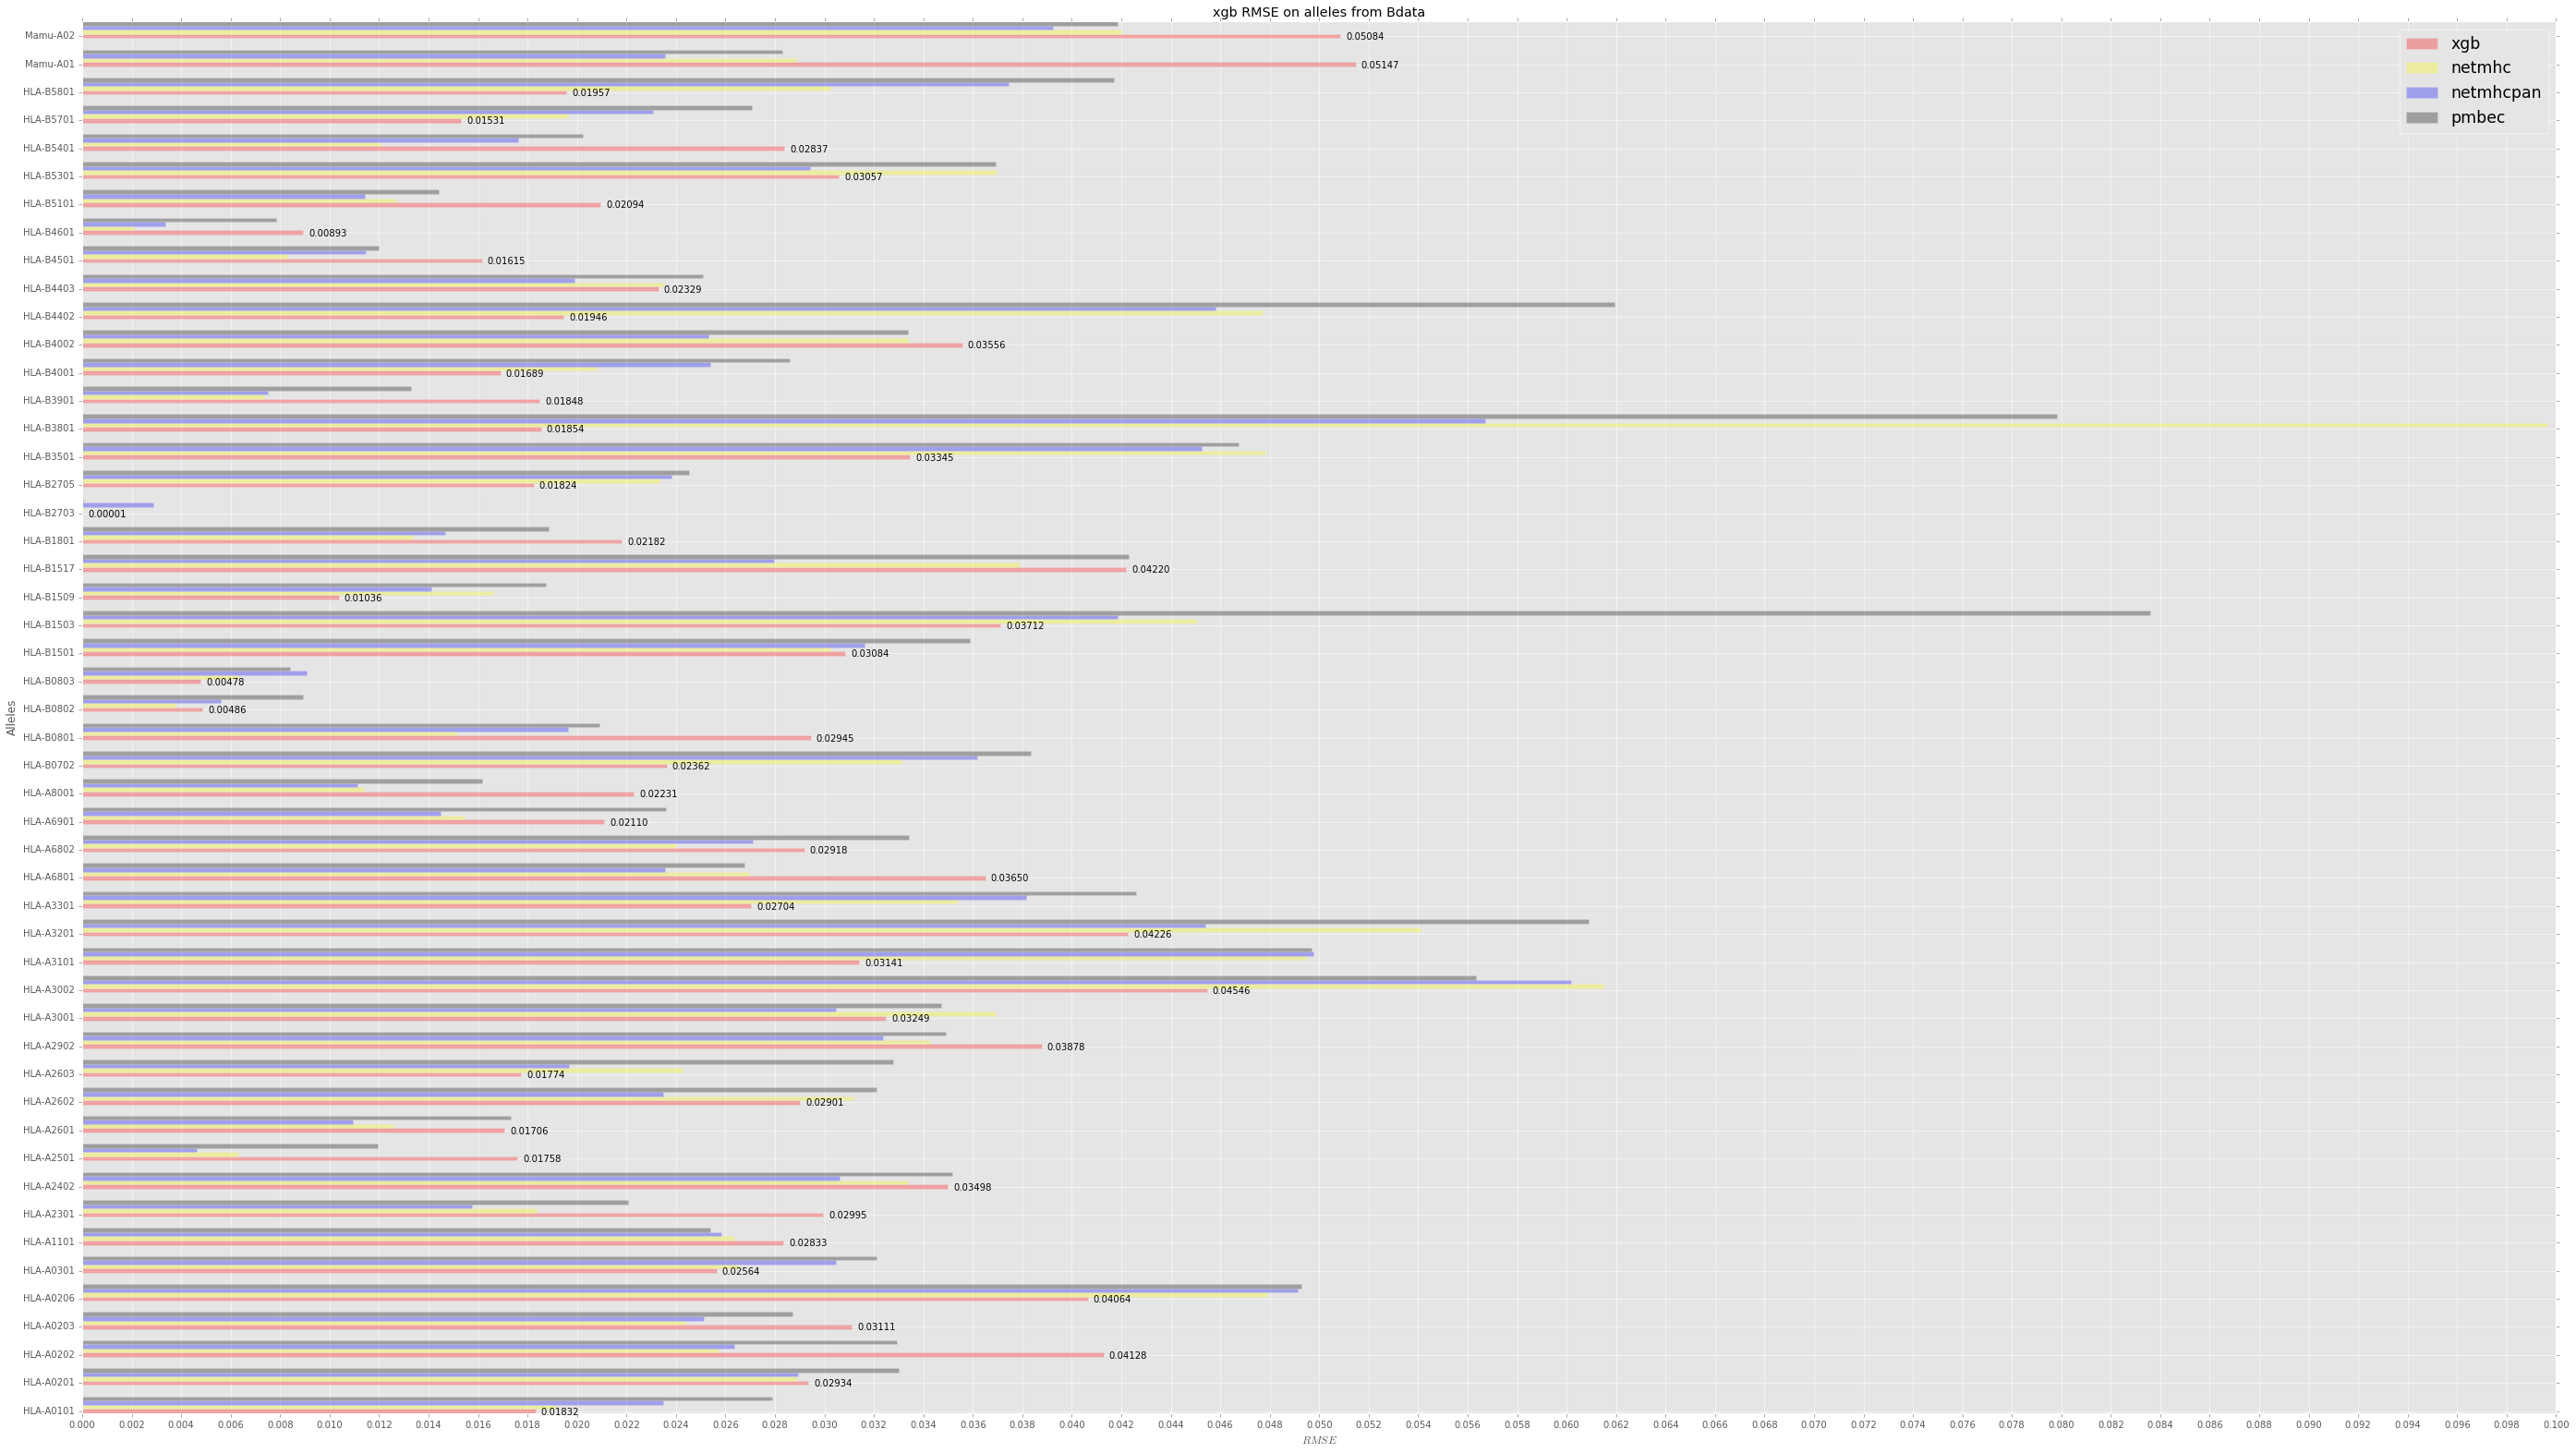

In [46]:
allele_rmse_figure = plt.figure(figsize=(48, 27))
plt.title("xgb RMSE on alleles from Bdata")
plt.xlabel("$RMSE$")
plt.ylabel("Alleles")

ind = np.arange(0, 4*len(list(res.index)), 4) 
width = 0.6
ys = plt.yticks(ind, list(res.index), rotation=0)
plt.locator_params(nbins=len(res.xgb))

xgb_rects = plt.barh(ind, list(res.xgb), width, align='center', color='red', alpha=0.3, label = 'xgb', edgecolor='w')
plt.barh(ind + width , list(res.netmhc), width, align='center', color='yellow', alpha=0.3, label='netmhc')
plt.barh(ind + 2*width, list(res.netmhcpan), width, align='center', color='blue', alpha=0.3, label='netmhcpan')
plt.barh(ind + 3*width, list(res.pmbec), width, align='center', color='black', alpha=0.3, label='pmbec')

plt.legend(fontsize='xx-large')


rounded_rmse_xgb = ["{0:.5f}".format(i) for i in list(res.xgb)]

for cur_rect, value in zip(xgb_rects.patches, rounded_rmse_xgb):
    plt.text(cur_rect.get_width() +0.001, cur_rect.get_y() - 0.5, value, ha='center', va='bottom')


allele_rmse_figure.savefig('rmse_comp_alleles.png', dpi=allele_rmse_figure.dpi)

In [55]:
res.to_csv("comaring_perf_on_alleles.csv")